In [80]:
import sys
import os
import numpy as np
import pandas as pd
import dill
import argparse
from tqdm import tqdm
from pyquaternion import Quaternion
from kalman_filter import NonlinearKinematicBicycle
from IPython.display import Image

nu_path = './devkit/python-sdk/'
sys.path.append(nu_path)
sys.path.append("../../trajectron")

from nuscenes.nuscenes import NuScenes
from nuscenes.map_expansion.map_api import NuScenesMap
from nuscenes.utils.splits import create_splits_scenes
from environment import Environment, Scene, Node, GeometricMap, derivative_of

"""From the script:

python process_data.py
    --data=./v1.0-mini
    --version="v1.0-mini"
    --output_path=../processed
"""

data_path = "./v1.0-mini"
version = "v1.0-mini"
val_split = 0.15

Uses code from
<https://github.com/nutonomy/nuscenes-devkit>

In [17]:
# loads the mainstream
nusc = NuScenes(
        version=version,
        dataroot=data_path,
        verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.3 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


`def create_splits_scenes(verbose: bool = False) -> Dict[str, List[str]]`

Returns a mapping from split to scene names. The splits are as follows:
- train/val/test: The standard splits of the nuScenes dataset (700/150/150 scenes).
- mini_train/mini_val: Train and val splits of the mini subset used for visualization and debugging (8/2 scenes).
- train_detect/train_track: Two halves of the train split used for separating the training sets of detector and tracker if required.

In [28]:
help(create_splits_scenes)

Help on function create_splits_scenes in module nuscenes.utils.splits:

create_splits_scenes(verbose:bool=False) -> Dict[str, List[str]]
    Similar to create_splits_logs, but returns a mapping from split to scene names, rather than log names.
    The splits are as follows:
    - train/val/test: The standard splits of the nuScenes dataset (700/150/150 scenes).
    - mini_train/mini_val: Train and val splits of the mini subset used for visualization and debugging (8/2 scenes).
    - train_detect/train_track: Two halves of the train split used for separating the training sets of detector and
        tracker if required.
    :param verbose: Whether to print out statistics on a scene level.
    :return: A mapping from split name to a list of scenes names in that split.



In [21]:
splits = create_splits_scenes()
for split_name, split_scenes in splits.items():
    print(f"scenes in {split_name}:", *split_scenes[:3], "...")
print(splits['mini_train'])

scenes in train: scene-0001 scene-0002 scene-0004 ...
scenes in val: scene-0003 scene-0012 scene-0013 ...
scenes in test: scene-0077 scene-0078 scene-0079 ...
scenes in mini_train: scene-0061 scene-0553 scene-0655 ...
scenes in mini_val: scene-0103 scene-0916 ...
scenes in train_detect: scene-0001 scene-0002 scene-0041 ...
scenes in train_track: scene-0004 scene-0005 scene-0006 ...
['scene-0061', 'scene-0553', 'scene-0655', 'scene-0757', 'scene-0796', 'scene-1077', 'scene-1094', 'scene-1100']


In [22]:
# take scenes in (mini_train, mini_val) and convert these to (train, val, test) sets.
from sklearn.model_selection import train_test_split
train_scenes, val_scenes = train_test_split(
    splits['train' if 'mini' not in version else 'mini_train'], test_size=val_split)
train_scene_names = splits['train' if 'mini' not in version else 'mini_train']
val_scene_names = val_scenes
test_scene_names = splits['val' if 'mini' not in version else 'mini_val']

print("(train, val, test)")
print(train_scene_names, val_scene_names, test_scene_names)

(train, val, test)
['scene-0061', 'scene-0553', 'scene-0655', 'scene-0757', 'scene-0796', 'scene-1077', 'scene-1094', 'scene-1100'] ['scene-0796', 'scene-1100'] ['scene-0103', 'scene-0916']


In [25]:
ns_scene_names = dict()
ns_scene_names['train'] = train_scene_names
ns_scene_names['val'] = val_scene_names
ns_scene_names['test'] = test_scene_names

`def field2token(self, table_name: str, field: str, query) -> List[str]`

This function queries all records for a certain field value, and returns the tokens for the matching records.
Warning: this runs in linear time.

In [27]:
help(NuScenes.field2token)

Help on function field2token in module nuscenes.nuscenes:

field2token(self, table_name:str, field:str, query) -> List[str]
    This function queries all records for a certain field value, and returns the tokens for the matching records.
    :param table_name: Table name.
    :param field: Field name. See README.md for details.
    :param query: Query to match against. Needs to type match the content of the query field.
    :return: List of tokens for the matching records.



## Getting a scene from the dataset

In [44]:
# can't get access to scene metadata from main trainval set.
ns_scene_name = splits['train'][0]
try:
    ns_scene = nusc.get('scene', nusc.field2token('scene', 'name', ns_scene_name)[0])
except Exception as e:
    print(e)

list index out of range


In [71]:
# getting metadata from scene in mini dataset
ns_scene_name = ns_scene_names['train'][0]
ns_scene = nusc.get('scene', nusc.field2token('scene', 'name', ns_scene_name)[0])
print("looking at", ns_scene_name, "metadata")
ns_scene

looking at scene-0061 metadata


{'token': 'cc8c0bf57f984915a77078b10eb33198',
 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'nbr_samples': 39,
 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'name': 'scene-0061',
 'description': 'Parked truck, construction, intersection, turn left, following a van'}

In [72]:
ns_scene_name = ns_scene_names['val'][0]
ns_scene = nusc.get('scene', nusc.field2token('scene', 'name', ns_scene_name)[0])
print("looking at", ns_scene_name, "metadata")
ns_scene

looking at scene-0796 metadata


{'token': 'c5224b9b454b4ded9b5d2d2634bbda8a',
 'log_token': '8ff48ad1df8e4966a2151730c92b7f3c',
 'nbr_samples': 40,
 'first_sample_token': 'c1676a2feac74eee8aa38ca3901787d6',
 'last_sample_token': '63c24b51feb94f14bec29022dae4975d',
 'name': 'scene-0796',
 'description': 'Scooter, peds on sidewalk, bus, cars, truck, fake construction worker, bicycle, cross intersection, car overtaking us'}

## Start processing the scene

First process scene by looping over each sample in the scene and:

1. extracting all the pedestrian and other vehicle annotations from the sample
2. extract ego vehicle pose and cam data

In [94]:
# every scene has a sample (snapshot of a scene in time?)
# extracting a sample from scene
ns_scene_name = ns_scene_names['train'][0]
ns_scene_token = nusc.field2token('scene', 'name', ns_scene_name)[0]
print("looking at scene", ns_scene_name, "with token", ns_scene_token)

ns_scene = nusc.get('scene', ns_scene_token)
sample_token = ns_scene['first_sample_token']
print("first_sample_token:", sample_token)
sample = nusc.get('sample', sample_token)
print("keys in sample:", *sample.keys())
print("timestamp:", sample['timestamp'])
print("next sample:", sample['next'])
print("prev sample:", sample['next'])
print("scene_token:", sample['scene_token'])
print("we have tokens for the following data:", *sample['data'].keys())
print(f"    that look like", sample['data']['RADAR_FRONT'])
annotation_tokens = sample['anns']
print("annotation tokens look like", annotation_tokens[0])
print(f"    there are {len(annotation_tokens)} of them")

looking at scene scene-0061 with token cc8c0bf57f984915a77078b10eb33198
first_sample_token: ca9a282c9e77460f8360f564131a8af5
keys in sample: token timestamp prev next scene_token data anns
timestamp: 1532402927647951
next sample: 39586f9d59004284a7114a68825e8eec
prev sample: 39586f9d59004284a7114a68825e8eec
scene_token: cc8c0bf57f984915a77078b10eb33198
we have tokens for the following data: RADAR_FRONT RADAR_FRONT_LEFT RADAR_FRONT_RIGHT RADAR_BACK_LEFT RADAR_BACK_RIGHT LIDAR_TOP CAM_FRONT CAM_FRONT_RIGHT CAM_BACK_RIGHT CAM_BACK CAM_BACK_LEFT CAM_FRONT_LEFT
    that look like 37091c75b9704e0daa829ba56dfa0906
annotation tokens look like ef63a697930c4b20a6b9791f423351da
    there are 69 of them


In [84]:
# extracting an annotation from sample
annotation_token = annotation_tokens[0]
annotation = nusc.get('sample_annotation', annotation_token)
print("looking at", annotation_token, "metadata")
annotation

looking at ef63a697930c4b20a6b9791f423351da metadata


{'token': 'ef63a697930c4b20a6b9791f423351da',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'instance_token': '6dd2cbf4c24b4caeb625035869bca7b5',
 'visibility_token': '1',
 'attribute_tokens': ['4d8821270b4a47e3a8a300cbec48188e'],
 'translation': [373.256, 1130.419, 0.8],
 'size': [0.621, 0.669, 1.642],
 'rotation': [0.9831098797903927, 0.0, 0.0, -0.18301629506281616],
 'prev': '',
 'next': '7987617983634b119e383d8a29607fd7',
 'num_lidar_pts': 1,
 'num_radar_pts': 0,
 'category_name': 'human.pedestrian.adult'}

In [85]:
# extract attributes from annotation
nusc.get('attribute', annotation['attribute_tokens'][0])

{'token': '4d8821270b4a47e3a8a300cbec48188e',
 'name': 'pedestrian.standing',
 'description': 'The human is standing.'}

In [89]:
# extract cam front data from sample
cam_front_token = sample['data']['CAM_FRONT']
print("looking at", cam_front_token, "metadata")
sample_data = nusc.get('sample_data', cam_front_token)
sample_data

looking at e3d495d4ac534d54b321f50006683844 metadata


{'token': 'e3d495d4ac534d54b321f50006683844',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'ego_pose_token': 'e3d495d4ac534d54b321f50006683844',
 'calibrated_sensor_token': '1d31c729b073425e8e0202c5c6e66ee1',
 'timestamp': 1532402927612460,
 'fileformat': 'jpg',
 'is_key_frame': True,
 'height': 900,
 'width': 1600,
 'filename': 'samples/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402927612460.jpg',
 'prev': '',
 'next': '68e8e98cf7b0487baa139df808641db7',
 'sensor_modality': 'camera',
 'channel': 'CAM_FRONT'}

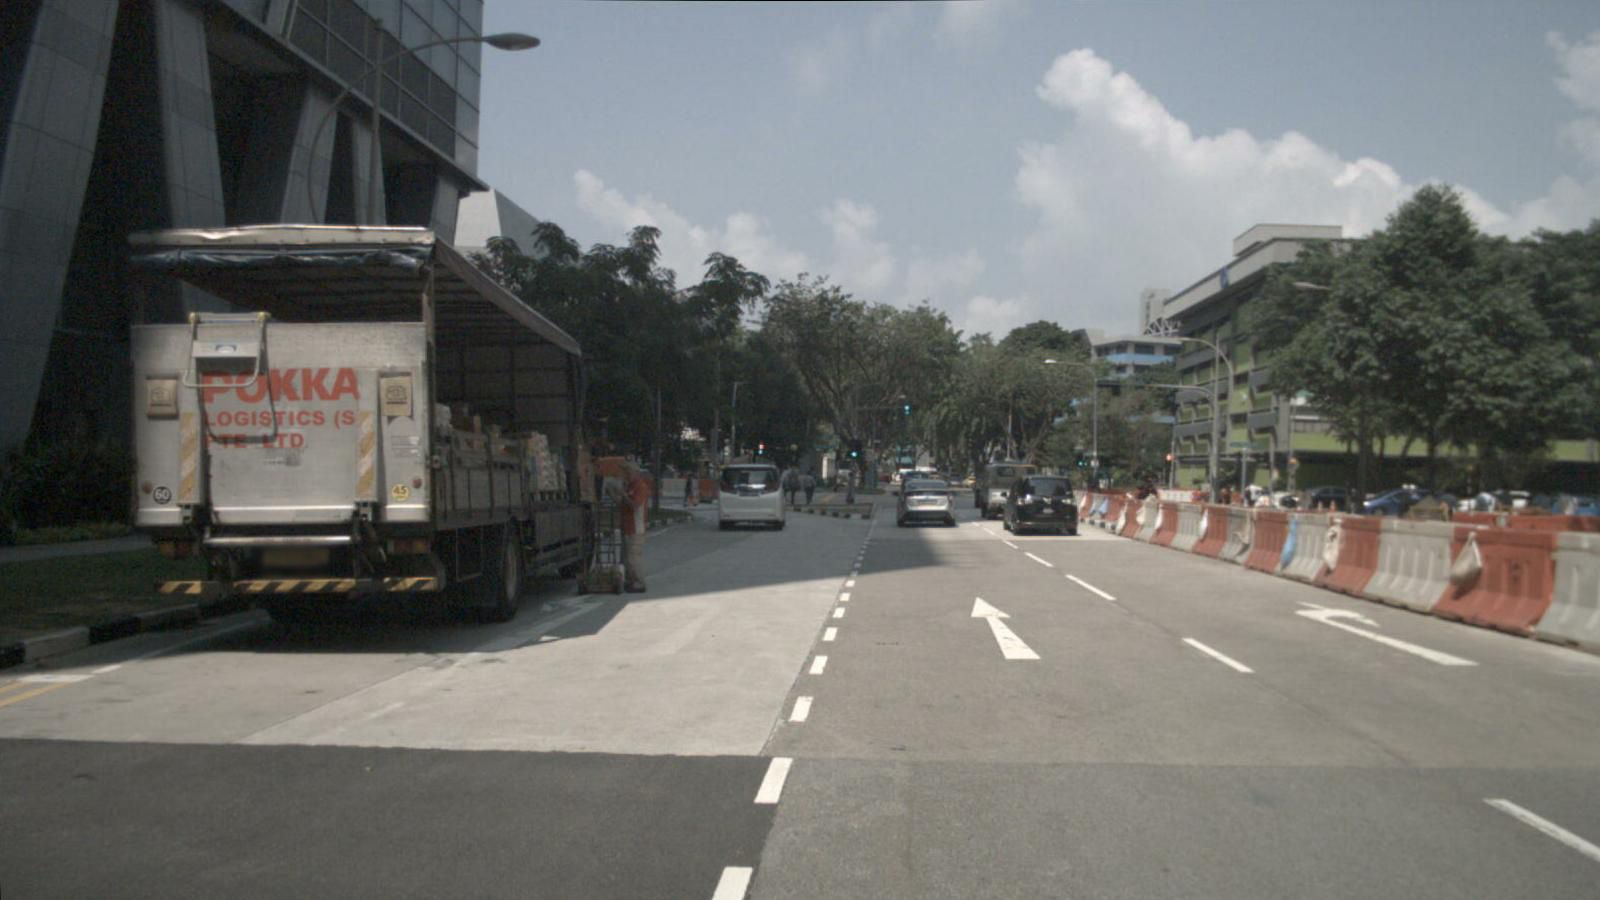

In [88]:
Image(os.path.join(data_path, sample_data['filename']))

In [90]:
# extract ego vehicle pose from cam front data (what is this?)
annotation = nusc.get('ego_pose', sample_data['ego_pose_token'])
annotation

{'token': 'e3d495d4ac534d54b321f50006683844',
 'timestamp': 1532402927612460,
 'rotation': [0.5720063498929273,
  -0.0021434844534272707,
  0.011564094980151613,
  -0.8201648693182716],
 'translation': [411.4199861830012, 1181.197175631848, 0.0]}

## Process more of the scene

In [97]:
help(NuScenesMap)

Help on class NuScenesMap in module nuscenes.map_expansion.map_api:

class NuScenesMap(builtins.object)
 |  NuScenesMap database class for querying and retrieving information from the semantic maps.
 |  Before using this class please use the provided tutorial in `map_demo.ipynb`.
 |  
 |  Below you can find the map origins (south eastern corner, in [lat, lon]) for each of the 4 maps in nuScenes:
 |  boston-seaport: [42.336849169438615, -71.05785369873047]
 |  singapore-onenorth: [1.2882100868743724, 103.78475189208984]
 |  singapore-hollandvillage: [1.2993652317780957, 103.78217697143555]
 |  singapore-queenstown: [1.2782562240223188, 103.76741409301758]
 |  
 |  The dimensions of the maps are as follows ([width, height] in meters):
 |  singapore-onenorth: [1585.6, 2025.0]
 |  singapore-hollandvillage: [2808.3, 2922.9]
 |  singapore-queenstown: [3228.6, 3687.1]
 |  boston-seaport: [2979.5, 2118.1]
 |  The rasterized semantic maps (e.g. singapore-onenorth.png) published with nuScenes v1

In [96]:
ns_scene_name = ns_scene_names['train'][0]
ns_scene_token = nusc.field2token('scene', 'name', ns_scene_name)[0]
print("looking at scene", ns_scene_name, "with token", ns_scene_token)
ns_scene = nusc.get('scene', ns_scene_token)

map_name = nusc.get('log', ns_scene['log_token'])['location']
print("the scene is in map", map_name)

nusc_map = NuScenesMap(dataroot=data_path, map_name=map_name)
# what is in nusc_map?

looking at scene scene-0061 with token cc8c0bf57f984915a77078b10eb33198
the scene is in map singapore-onenorth
